In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
def parser(x):
	return datetime.strptime( x, '%Y-%m-%d')
 
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# **Dataset Birth**

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/BCML/datasets/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

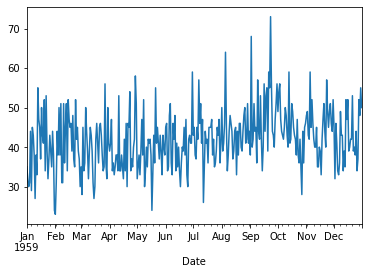

In [5]:
dataset.plot()
plt.show()

## **Penentuan Lag**

In [ ]:
values = dataset.values
size = int(len(values) * 0.75)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []


In [ ]:
model = AR(train)
model_fit = model.fit()
print('Lag:', model_fit.k_ar)

Lag: 15


In [ ]:
dataset_values = dataset.values

def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.75)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
	print('RMSE = %.2f'%(sqrt(best_score)))

In [ ]:
import warnings

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")
evaluate_models(dataset_values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=45.405
ARIMA(0, 0, 1) MSE=41.620
ARIMA(0, 0, 2) MSE=40.567
ARIMA(0, 1, 0) MSE=58.455
ARIMA(0, 1, 1) MSE=44.235
ARIMA(0, 1, 2) MSE=42.342
ARIMA(0, 2, 0) MSE=167.269
ARIMA(0, 2, 1) MSE=58.862
ARIMA(1, 0, 0) MSE=40.595
ARIMA(1, 0, 1) MSE=41.727
ARIMA(1, 1, 0) MSE=47.747
ARIMA(1, 1, 1) MSE=42.153
ARIMA(1, 1, 2) MSE=43.191
ARIMA(1, 2, 0) MSE=103.386
ARIMA(2, 0, 0) MSE=39.523
ARIMA(2, 0, 1) MSE=39.778
ARIMA(2, 0, 2) MSE=40.583
ARIMA(2, 1, 0) MSE=42.871
ARIMA(2, 1, 1) MSE=41.882
ARIMA(2, 1, 2) MSE=42.284
ARIMA(2, 2, 0) MSE=77.984
ARIMA(3, 0, 0) MSE=39.027
ARIMA(3, 0, 1) MSE=39.532
ARIMA(3, 0, 2) MSE=39.598
ARIMA(3, 1, 0) MSE=41.486
ARIMA(3, 1, 1) MSE=42.290
ARIMA(3, 1, 2) MSE=43.131
ARIMA(3, 2, 0) MSE=63.026
ARIMA(4, 0, 0) MSE=38.845
ARIMA(4, 0, 1) MSE=42.206
ARIMA(4, 0, 2) MSE=38.719
ARIMA(4, 1, 0) MSE=42.619
ARIMA(4, 1, 1) MSE=42.548
ARIMA(4, 1, 2) MSE=41.689
ARIMA(4, 2, 0) MSE=57.109
Best ARIMA(4, 0, 2) MSE=38.719
RMSE = 6.22


## **Train Test Split**

In [6]:
#didapat lag 4 
lag = 4

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [7]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0,0,0,0
0,NaN,NaN,NaN,NaN,-3
1,-3.0,NaN,NaN,NaN,-2
2,-2.0,-3.0,NaN,NaN,1
3,1.0,-2.0,-3.0,NaN,13
4,13.0,1.0,-2.0,-3.0,-15
...,...,...,...,...,...
359,-10.0,6.0,-2.0,1.0,3
360,3.0,-10.0,6.0,-2.0,15
361,15.0,3.0,-10.0,6.0,-4
362,-4.0,15.0,3.0,-10.0,7


In [9]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ 13.,   1.,  -2.,  -3., -15.],
       [-15.,  13.,   1.,  -2.,  16.],
       [ 16., -15.,  13.,   1.,  -2.],
       ...,
       [ 15.,   3., -10.,   6.,  -4.],
       [ -4.,  15.,   3., -10.,   7.],
       [  7.,  -4.,  15.,   3.,  -5.]])

In [10]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Baseline model

In [12]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1044 - val_loss: 0.0650
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1038 - val_loss: 0.0646
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1034 - val_loss: 0.0642
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1028 - val_loss: 0.0638
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1025 - val_loss: 0.0635
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1020 - val_loss: 0.0632
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1016 - val_loss: 0.0629
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1012 - val_loss: 0.0626
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1008 - val_loss: 0.0624
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1005 - val_loss: 0.0620
Epoch 11/1000
9/9 

In [13]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0547
Test loss: 0.05471290647983551


In [14]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
186,0.073351,0.052760,186
187,0.073297,0.052763,187
185,0.073453,0.052769,185
188,0.073220,0.052778,188
189,0.073183,0.052846,189
...,...,...,...
4,0.102467,0.063475,4
3,0.102816,0.063838,3
2,0.103372,0.064168,2
1,0.103777,0.064601,1


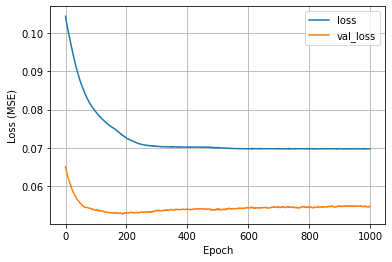

In [15]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [16]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.1121 - val_loss: 0.0710
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1117 - val_loss: 0.0707
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1115 - val_loss: 0.0705
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1113 - val_loss: 0.0703
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1111 - val_loss: 0.0702
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.0701
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.0700
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.0699
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.0699
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1107 - val_loss: 0.0698
Epoch 11/1000
9/9 

In [17]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
126,0.076760,0.050450,126
151,0.074747,0.050464,151
144,0.075142,0.050473,144
143,0.075200,0.050474,143
141,0.075338,0.050475,141
...,...,...,...
4,0.111112,0.070163,4
3,0.111300,0.070300,3
2,0.111451,0.070509,2
1,0.111719,0.070691,1


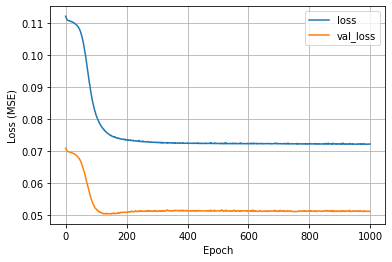

In [18]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [19]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1273 - val_loss: 0.0699
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1113 - val_loss: 0.0632
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1009 - val_loss: 0.0596
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0571
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0890 - val_loss: 0.0548
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0534
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0520
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0511
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0781 - val_loss: 0.0506
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0767 - val_loss: 0.0502
Epoch 11/1000
9/9 

In [20]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
14,0.071605,0.049072,14
20,0.068792,0.049164,20
13,0.072360,0.049327,13
11,0.073947,0.049353,11
15,0.070843,0.049373,15
...,...,...,...
949,0.044355,0.064682,949
979,0.044244,0.064859,979
998,0.044141,0.065088,998
929,0.044804,0.065113,929


# **LSTM**

In [21]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 0.1097 - val_loss: 0.0689
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1073 - val_loss: 0.0673
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1050 - val_loss: 0.0661
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1029 - val_loss: 0.0649
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1009 - val_loss: 0.0636
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0989 - val_loss: 0.0625
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0969 - val_loss: 0.0614
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0950 - val_loss: 0.0603
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0931 - val_loss: 0.0592
Epoch 10/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0912 - val_loss: 0.0582
Epoch 11/1000
9/9 

In [22]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
27,0.070796,0.049940,27
31,0.069502,0.050003,31
28,0.070450,0.050021,28
33,0.069221,0.050044,33
26,0.071265,0.050048,26
...,...,...,...
977,0.050747,0.065801,977
995,0.050734,0.065889,995
2,0.104994,0.066076,2
1,0.107313,0.067341,1


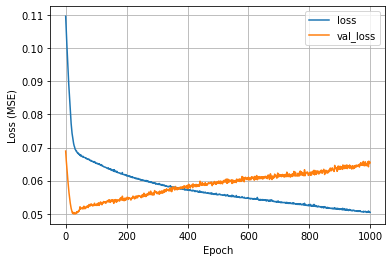

In [23]:
plot_loss(lstm_model_history)

# **Kesimpulan**

Berdasarkan perhitungan diatas dengan lag terbaik yakni 4 (berdasarkan hasil perhitungan ARIMA) didapatkan hasil:

```
Baseline Model: Val_loss 0.052760 Epoch 186
Deeper Model: Val_loss 0.050450 Epoch 126
Wider Model: Val_loss 0.049072 Epoch 14
LSTM: Val_loss 0.049940 Epoch 27
```
melihat dari hasil val_loss yang ada maka dapat di simpulkan **Wider Model** mendapatkan hasil yang **terbaik** karena val_loss semakin kecil semakin baik dan juga jika di bandingkan antara lag nya maka lag 4 lebih baik di bandingkan lag 1 ini membuktikan bahwa lag mempengaruhi tingkat akurasi dalam model atau arsitektur TimeSeries.
